In [1]:
import requests
import pandas as pd
import numpy as np
import time
from itertools import product
import matplotlib.pyplot as plt

## Get Data

In [2]:
def get_binance_future(symbol, interval, start_time, end_time):
    url = "https://fapi.binance.com/fapi/v1/klines"
    df_list = []

    start_time = int(pd.to_datetime(start_time).timestamp() * 1000)
    end_time = int(pd.to_datetime(end_time).timestamp() * 1000)

    while start_time < end_time:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_time,
            "endTime": end_time,
            "limit": 1500
        }

        resp = requests.get(url, params = params)
        data = resp.json()

        if not data:
            start_time = pd.to_datetime(start_time, unit = "ms")
            end_time = pd.to_datetime(end_time, unit = "ms")
            print(f"No data for {symbol} from {start_time} to {end_time}")
            break

        df = pd.DataFrame(data, columns = [
            "openTime", "open", "high", "low", "close", "volume",
            "closeTime", "quoteAssetVolume", "numberOfTrades",
            "takerBuyBaseAssetVolume", "takerBuyQuoteAssetVolume", "ignore"
            ])
        
        df = df.drop(columns = ["quoteAssetVolume", "numberOfTrades", "takerBuyBaseAssetVolume", "takerBuyQuoteAssetVolume", "ignore"])
        df_list.append(df)

        last_time = int(df["closeTime"].iloc[-1])
        start_time = last_time + 1
        time.sleep(0.3)

    if df_list:
        df_all = pd.concat(df_list, ignore_index = True)
        df_all["closeTime"] = pd.to_datetime(df_all["closeTime"], unit = "ms").dt.strftime("%Y-%m-%d %H:%M:%S")
        df_all["openTime"] = pd.to_datetime(df_all["openTime"], unit = "ms").dt.strftime("%Y-%m-%d %H:%M:%S")
        df_all.set_index("closeTime", inplace = True)
        df_all[["open", "high", "low", "close", "volume"]] = df_all[["open", "high", "low", "close", "volume"]].astype(float)
        return df_all

    return pd.DataFrame()

In [3]:
symbol = "BTCUSDT"
interval = "4h"
start = "2021-01-01"
end = pd.to_datetime("now")

df = get_binance_future("BTCUSDT", interval, start, end)

No data for BTCUSDT from 2025-03-29 12:00:00 to 2025-03-29 16:48:21.487000


## Strategy

### Indicators

In [4]:
def get_ema(df, span):
    return df["close"].ewm(span = span, adjust = False).mean()

In [5]:
def get_macd(df, fast = 12, slow = 26, signal = 9):
    df = df.copy()

    ema_fast = df["close"].ewm(span = fast, adjust = False).mean()
    ema_slow = df["close"].ewm(span = slow, adjust = False).mean()
    
    dif = ema_fast - ema_slow
    macd = dif.ewm(span = signal, adjust = False).mean()
    hist = dif - macd

    return dif, macd, hist

In [6]:
def get_rsi(df, period = 14):
    delta = df["close"].diff()
    gain = delta.clip(lower = 0)
    loss = -delta.clip(upper = 0)

    avg_gain = gain.rolling(window = period).mean()
    avg_loss = loss.rolling(window = period).mean()

    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [96]:
def get_sma(df, window):
    return df["close"].rolling(window=window).mean()

In [97]:
def get_volume_average(df, window):
    return df["volume"].rolling(window=window).mean()

### Strategy  
用以產生交易訊號

In [111]:
def ma_strategy(df, ma1 = 10, ma2 = 30):
    """
    測試用的策略，不重要
    """
    df = df.copy()

    df["ma_short"] = df["close"].rolling(ma1).mean()
    df["ma_long"] = df["close"].rolling(ma2).mean()

    entry = df["ma_short"] > df["ma_long"]
    exit = df["ma_long"] > df["ma_short"]

    df.loc[entry, "signal"] = 1
    df.loc[exit, "signal"] = 0

    return df["signal"]

In [118]:
def ma_volume_strategy(df, short_window = 10, long_window = 50, volume_window = 20):
    df = df.copy()
    
    df["sma_short"] = get_sma(df, short_window)
    df["sma_long"] = get_sma(df, long_window)
    
    df["volume_avg"] = get_volume_average(df, volume_window)

    condition1 = df["close"] > df["sma_short"]
    condition2 = df["volume"] > df["volume_avg"]
    condition3 = df["close"] < df["sma_short"]
    condition4 = df["volume"] > df["volume_avg"]
    
    entry_condition = condition1 & condition2
    exit_condition = condition3 & condition4

    df["signal"] = 0

    # 目前持有狀態
    BS = None
    for i in range(1, len(df)):
        if entry_condition.iloc[i] and BS != "B":
            df.loc[df.index[i], "signal"] = 1
            BS = "B"
        elif exit_condition.iloc[i] and BS != None:
            df.loc[df.index[i], "signal"] = 0
            BS = None

    return df["signal"]

In [137]:
def momentum_confirmation_strategy(df, ema_short, ema_long, rsi_period):
    df = df.copy()
    
    df[f"ema_{ema_long}"] = get_ema(df, ema_long)
    df[f"ema_{ema_short}"] = get_ema(df, ema_short)

    df["dif"], df["macd"], _ = get_macd(df)

    df["rsi"] = get_rsi(df, rsi_period)
    
    condition1 = (df["close"] > df[f"ema_{ema_short}"]) & (df[f"ema_{ema_short}"] > df[f"ema_{ema_long}"])
    condition2 = df["dif"] > df["macd"]
    condition3 = df["rsi"] > 60

    condition4 = df["dif"] < df["macd"]
    condition5 = df["rsi"] < 30

    entry_condition = condition1 & condition2 & condition3
    exit_condition = condition5

    df["signal"] = 0

    # 目前持有狀態
    BS = None
    for i in range(1, len(df)):
        if entry_condition.iloc[i] and BS != "B":
            df.loc[df.index[i], "signal"] = 1
            BS = "B"
        elif exit_condition.iloc[i] and BS != None:
            df.loc[df.index[i], "signal"] = 0
            BS = None

    return df["signal"]

### Backtest  
根據交易信號決定持倉與否

In [112]:
def backtest(df, strategy, cost, rolling = False, **kwargs):
    """
    產生策略的dataframe
    """
    result = df.copy()
    result["signal"] = strategy(df, **kwargs)

    result.index = pd.to_datetime(result.index, errors = 'coerce')
    result["openTime"] = pd.to_datetime(result["openTime"], errors = 'coerce')

    result["position"] = result["signal"].shift(1).fillna(0)
    result["return"] = np.log(result["close"] / result["close"].shift(1))
    result["strategy"] = result["position"] * result["return"]
    result["trade"] = result["position"].diff().abs()
    result["strategy_net"] = result["strategy"] - result["trade"] * cost

    result["cum_strategy_percent_no_cost"] = np.exp(result["strategy"].fillna(0).cumsum())
    result["cum_market_percent"] = np.exp(result["return"].fillna(0).cumsum())
    result["cum_strategy_percent"] = np.exp(result["strategy_net"].fillna(0).cumsum())
        
    return result

In [119]:
def get_performance(result):
    """
    計算績效指標
    """
    performance = {}
    if result.empty or "cum_strategy_percent" not in result.columns:
        performance["total_return"] = 0.0
        performance["annualized_return"] = 0.0
        performance["volatility"] = 0.0
        performance["sharpe_ratio"] = 0.0
        performance["max_drawdown"] = 0.0
        performance["profit_factor"] = 0.0
        return performance

    performance["total_return"] = float(result["cum_strategy_percent"].iloc[-1] - 1)
    performance["annualized_return"] = float((1 + performance["total_return"]) ** (365 / len(result)) - 1)
    performance["volatility"] = float(result["strategy"].std() * np.sqrt(365))
    
    strategy_mean = result["strategy"].mean()
    strategy_std = result["strategy"].std()
    if strategy_std != 0:
        performance["sharpe_ratio"] = float(strategy_mean / strategy_std * np.sqrt(365))
    else:
        performance["sharpe_ratio"] = np.nan
    
    performance["sharpe_ratio"] = float(result["strategy"].mean() / result["strategy"].std() * np.sqrt(365))
    performance["max_drawdown"] = float((result["cum_strategy_percent"].cummax() - result["cum_strategy_percent"]).max())

    gross_profit = result.loc[result["strategy"] > 0, "strategy"].sum()
    gross_loss = -result.loc[result["strategy"] < 0, "strategy"].sum()
    performance["profit_factor"] = gross_profit / gross_loss if gross_loss != 0 else np.inf

    return performance


In [138]:
"""
選擇策略進行回測
params 要更改成符合該策略的param
"""

strategy = momentum_confirmation_strategy
cost = 0.0005
params = {
    "ema_short": 20,
    "ema_long": 50,
    "rsi_period": 14
}

result = backtest(df, strategy, cost, **params)
performance = get_performance(result)
# result
# performance

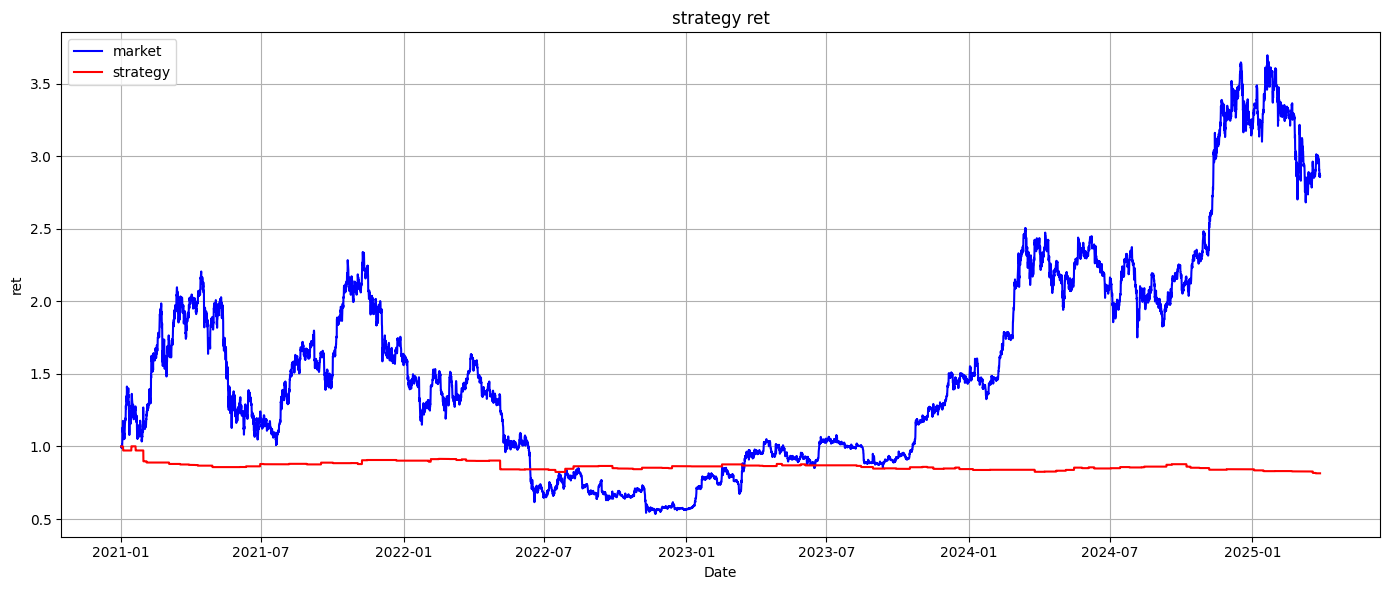

In [ ]:
"""
畫出策略報酬圖
"""
plt.figure(figsize = (14, 6), facecolor = 'white')
ax = plt.gca()
ax.set_facecolor('white')

plt.plot(result.index, result["cum_market_percent"], label="market", color="blue")
plt.plot(result.index, result["cum_strategy_percent"], label="strategy", color="red")

plt.title("strategy ret")
plt.xlabel("Date")
plt.ylabel("ret")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Optimize

In [ ]:
def rolling_window(df, strategy, param_grid, n_window, train_ratio, test_ratio, cost, focus_indicator, **kwargs):
    """
    以 rolling windows 進行參數優化並回測
    """
    result = []
    total_size = len(df)

    if train_ratio + test_ratio != 1:
        raise ValueError("Sum of train_ratio and test_ratio must be 1")
    
    window = total_size // (1 + test_ratio * (n_window - 1))
    train_size = int(window * train_ratio)
    test_size = int(window * test_ratio)

    if train_size + test_size > total_size:
        raise ValueError("Window size is too large for the dataset")

    i = 0
    window_num = 1

    while i + train_size + test_size <= len(df):
        print(f"Processing window {window_num}")
        
        train = df.iloc[i: i + train_size]

        best_score = -np.inf
        best_param = None

        for combo in product(*param_grid.values()):
            params = dict(zip(param_grid.keys(), combo))
            result_df = backtest(train, strategy, cost, **params)
            performance = get_performance(result_df)
            score = performance[focus_indicator]
        
            if score > best_score:
                best_score = score
                best_param = params

        result_df = backtest(df, strategy, cost, **best_param)
        test_result = result_df.iloc[i + train_size: i + train_size + test_size]
        result.append(test_result)

        i += test_size
        window_num += 1
        
    full = pd.concat(result)
    full["cum_strategy_percent_no_cost"] = np.exp(full["strategy"].fillna(0).cumsum())
    full["cum_market_percent"] = np.exp(full["return"].fillna(0).cumsum())
    full["cum_strategy_percent"] = np.exp(full["strategy_net"].fillna(0).cumsum())
    return full

In [147]:
# # momentum_confirmation_strategy params
# param_grid = {
#     "ema_short": list(range(5, 50, 3)),
#     "ema_long": list(range(50, 101, 10)),
#     "rsi_period": list(range(10, 40, 3))
# }

# ma_volume_strategy params
param_grid = {
    "short_window": list(range(10, 50, 3)),
    "long_window": list(range(50, 101, 10)),
    "volume_window": list(range(20, 40, 3))
}

optimize_result = rolling_window(
    df,
    strategy = ma_volume_strategy,
    param_grid = param_grid,
    n_window = 7,
    train_ratio = 0.7,
    test_ratio = 0.3,
    cost = 0.0005,
    focus_indicator = "total_return"
)

Processing window 1
Processing window 2
Processing window 3
Processing window 4
Processing window 5
Processing window 6
Processing window 7


## Performance

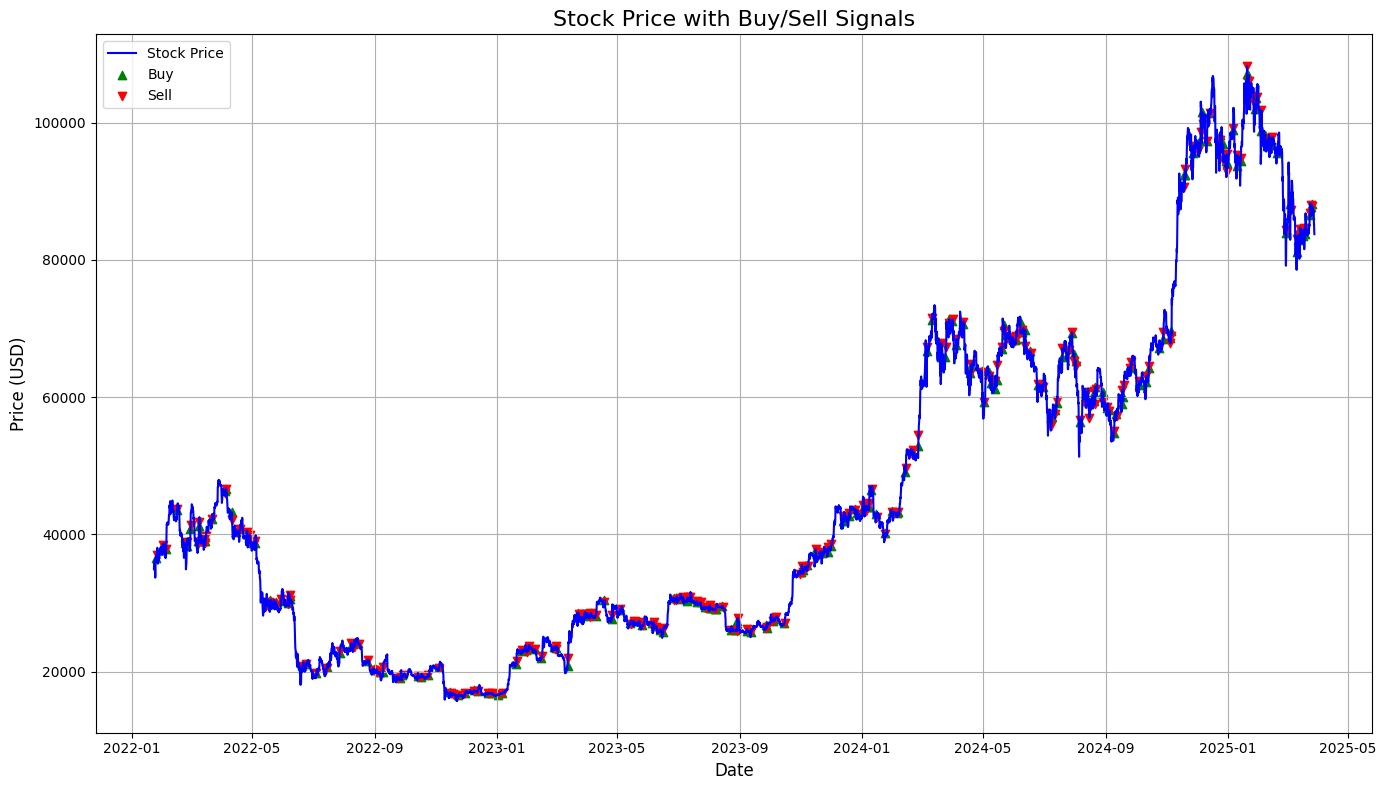

In [ ]:
plt.figure(figsize=(14, 8))

plt.plot(optimize_result.index, optimize_result['close'], label = 'Stock Price', color = 'blue')

buy_signals = optimize_result[optimize_result['signal'] == 1]

# sell： signal 由 1 變為 0
sell_signals = optimize_result[(optimize_result['signal'] == 0) & (optimize_result['signal'].shift(1) == 1)]

plt.scatter(buy_signals.index, buy_signals['close'], marker = '^', color = 'green', label = 'Buy', alpha = 1)
plt.scatter(sell_signals.index, sell_signals['close'], marker = 'v', color = 'red', label = 'Sell', alpha = 1)

plt.title('Stock Price with Buy/Sell Signals', fontsize = 16)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Price (USD)', fontsize = 12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

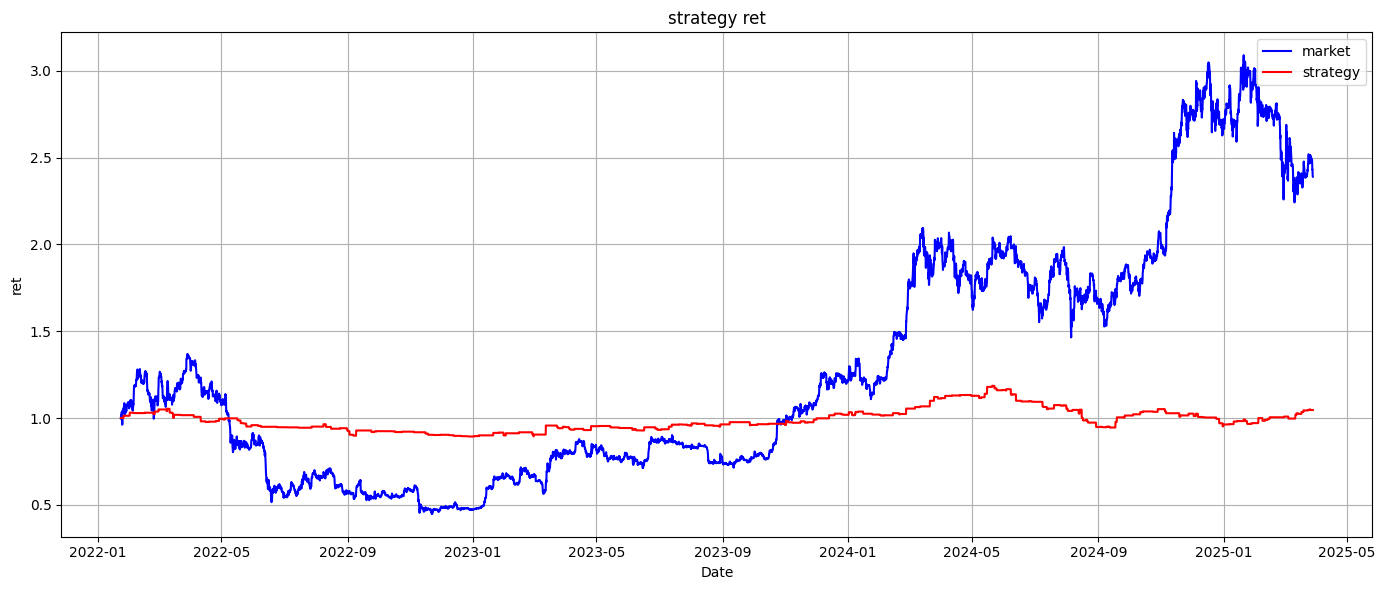

In [149]:
plt.figure(figsize = (14, 6), facecolor = 'white')
ax = plt.gca()
ax.set_facecolor('white')

plt.plot(optimize_result.index, optimize_result["cum_market_percent"], label = "market", color = "blue")
plt.plot(optimize_result.index, optimize_result["cum_strategy_percent"], label = "strategy", color = "red")

plt.title("strategy ret")
plt.xlabel("Date")
plt.ylabel("ret")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
